In [139]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import tensorflow_hub as hub
import random

### 1. Image Augmentation

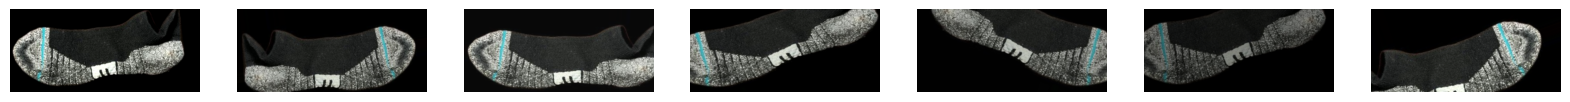

In [107]:
# TODO: Maybe remove rotation later
# TODO: Maybe remove horizontal flip later

np_img = np.array(Image.open("../1Data-Collection/Manual/Centered/IMG_0555.jpg"))
np_img = np_img.reshape(1, np_img.shape[0], np_img.shape[1], np_img.shape[2])

# Augumentation Configuration
roating_range = 20
# width_shift_range = 0.05
# height_shift_range = 0.05
width_shift_range = 0
height_shift_range = 0
brightness_range = [0.5, 1.3]
shear_range = 0
zoom_range = 0.15
channel_shift_range = 10
horizontal_flip = True
vertical_flip = False

datagen = ImageDataGenerator(rotation_range=roating_range, width_shift_range=width_shift_range, height_shift_range=height_shift_range, brightness_range=brightness_range, shear_range=shear_range, zoom_range=zoom_range, channel_shift_range=channel_shift_range, horizontal_flip=horizontal_flip, vertical_flip=vertical_flip)

aug_iter = datagen.flow(np_img, batch_size=1)

# Show augmented images variation
plt.figure(figsize=(20, 20))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.axis("off")
    plt.imshow(aug_iter.next().squeeze().astype(np.uint8))  



In [128]:
def generateAugumentedImages(img, imageCnt = 100):
    aug_iter = datagen.flow(img, batch_size=1)
    images = []

    for i in range(imageCnt):
        images.append(aug_iter.next().astype(np.uint8))
    return np.array(images)

### 2. Prepare the data

In [149]:
def load_images(shape, seed=1234, dataDir="../1Data-Collection/Manual/Centered/"):
  # Get all images
  random.seed(seed)

  images = os.listdir(dataDir)
  random.shuffle(images)
  images = [dataDir + i for i in images]

  # Load to numpy array
  np_images = []
  for i in tqdm(images):
      np_images.append(np.array(Image.open(i).resize(shape)))

  np_images = np.array(np_images).astype(np.float32)

  return np_images

### 3. Transfer Learning

In [283]:
def featureExtractor(model, shape, augCnt, preprocess_input, dataDir="../1Data-Collection/Manual/Centered/"):
  # Load images
  print("\nLoading Images...")
  np_img = load_images(shape, dataDir)

  # Augumentation
  print ("\nAugmenting Images...")
  aug_imgs = []
  for i in tqdm(range(np_img.shape[0])):
    aug_imgs.append(generateAugumentedImages(np.expand_dims(np_img[i], axis=0), augCnt))
  aug_imgs = np.array(aug_imgs)

  print("Augmented Images Shape:", aug_imgs.shape)

  # aug_imgs = preprocess_input(aug_imgs)
  aug_imgs = aug_imgs / 255.0

  # Visualize
  plt.figure(figsize=(10, 10))

  for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.axis("off")
      plt.imshow((aug_imgs[0][i] * 255).squeeze().astype(np.uint8))

  # Extract features
  print("\nExtracting Features...")
  features = []
  for i in tqdm(range(aug_imgs.shape[0])):
    features.append(model.predict(aug_imgs[i].squeeze(), verbose=0))
    
  features = np.array(features)
  print("Features Shape:", features.shape)

  return features

### 4. Preparing the extracted features and labels

In [247]:
def split_data(features, split_ratio=0.8, seed=1234):
  # Split data
  random.seed(seed)
  random.shuffle(features)

  split = int(features.shape[0] * split_ratio)

  train = features[:split]
  test = features[split:]

  return train, test

In [248]:
# This function take either train or test data and generate pairs and non-pairs
# TODO: This could be super memory intensive. Maybe we should generate pairs/non-pairs on the fly?
def getTrainTest(data, seed=1234):
  X = []
  y = []

  number_of_pairs = 0

  # Generating Pairs
  print("\nGenerating Pairs...")
  for i in tqdm(range(data.shape[0])): # For each socks
    for j in range(data.shape[1]): # For each augumented images
      for k in range(data.shape[1]): # For each other augumented images
        if j != k:
          X.append([data[i][j], data[i][k]])
          y.append(1)
          number_of_pairs += 1

  # Generating Non-Pairs
  print("\nGenerating Non-Pairs...")

  number_of_non_pairs = 0
  random.seed(seed)

  while number_of_non_pairs != number_of_pairs:
    sock1, sock2 = random.sample(range(data.shape[0]), 2)
    img1, img2 = random.sample(range(data.shape[1]), 2)

    X.append([data[sock1][img1], data[sock2][img2]])
    y.append(0)
    number_of_non_pairs += 1
  
  X = np.array(X)
  y = np.array(y)

  return X, y

In [249]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

# Load MobileNetV2
mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))


Loading Images...



100%|██████████| 49/49 [00:00<00:00, 143.76it/s]



Augmenting Images...
























100%|██████████| 49/49 [00:02<00:00, 18.34it/s]


Augmented Images Shape: (49, 2, 1, 224, 224, 3)

Extracting Features...




















































100%|██████████| 49/49 [00:11<00:00,  4.24it/s]


Features Shape: (49, 2, 7, 7, 1280)


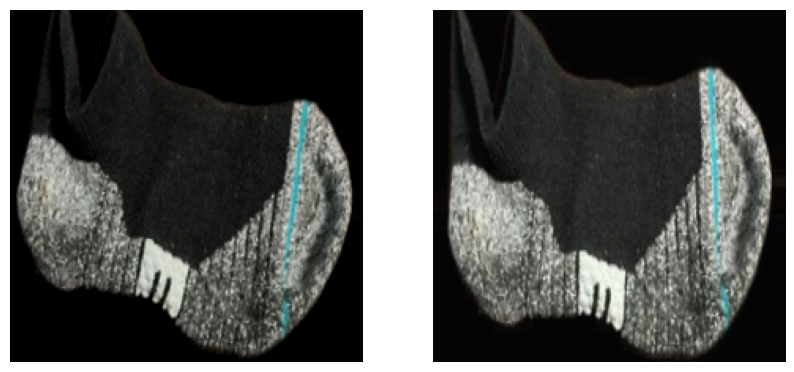

In [284]:
features = featureExtractor(mobilenet, (224, 224), 2, preprocess_input)

In [270]:
train, test = split_data(features)
train_X, train_y = getTrainTest(train)
test_X, test_y = getTrainTest(test)

print("Train X Shape:", train_X.shape)
print("Train y Shape:", train_y.shape)
print("Test X Shape:", test_X.shape)
print("Test y Shape:", test_y.shape)


Generating Pairs...



100%|██████████| 39/39 [00:00<00:00, 88997.75it/s]



Generating Non-Pairs...

Generating Pairs...



100%|██████████| 10/10 [00:00<00:00, 40329.85it/s]


Generating Non-Pairs...
Train X Shape: (156, 2, 7, 7, 1280)
Train y Shape: (156,)
Test X Shape: (40, 2, 7, 7, 1280)
Test y Shape: (40,)


In [271]:
# Euclidean Distance
def eud(npA, npB):
  npA = npA.flatten()
  npB = npB.flatten()

  return np.sqrt(np.sum(np.square(npA - npB)))

In [287]:
def findNonZero(npA, cnt):
  npA = npA.flatten()
  print(npA[npA != 0][:cnt])

findNonZero(features[0][0], 5)
findNonZero(features[0][1], 5)

[0.3496008  0.71725464 0.39678144 1.1934705  1.2677269 ]
[3.0293183  2.0061774  0.07078266 2.856783   1.5566287 ]


1/1 [==============================] - 0s 122ms/step
(2, 7, 7, 1280)
[0.72777224 1.4579182  0.22016954 5.50497    1.047111  ]
[0.67897797 0.23662424 0.33450317 0.2760806  1.2858281 ]


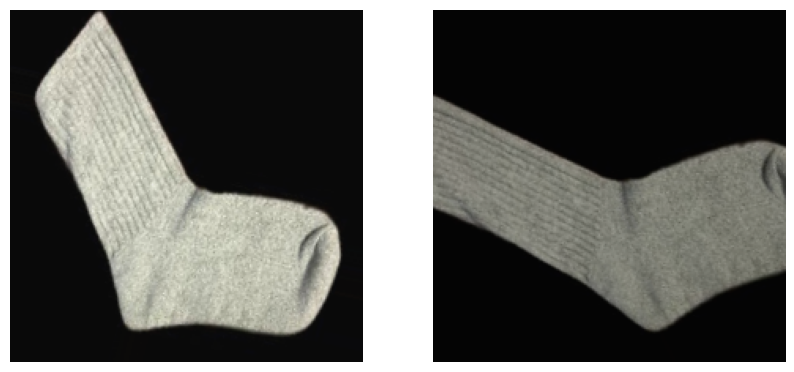

In [273]:
imageA = Image.open("../1Data-Collection/Manual/Centered/IMG_0556.jpg")

imageA = imageA.resize((224, 224))

imageA = np.array(imageA).astype(np.float32)

imageA = np.expand_dims(imageA, axis=0)

imageA = generateAugumentedImages(imageA, 2)

# imageA = preprocess_input(imageA)
imageA = imageA / 255.0

# Visualize
plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.axis("off")
    plt.imshow((imageA[i]*255).squeeze().astype(np.uint8))

imageA = imageA.squeeze()

pred = mobilenet.predict(imageA)

print(pred.shape)

findNonZero(pred[0], 5)
findNonZero(pred[1], 5)

# TODO: The preprocess is fucking with my image. While / 255 works fine. Check what this is doing.

[376.00232, 376.00232, 376.00232, 376.00232, 233.21439, 233.21439, 316.33124, 316.33124, 309.7432, 309.7432, 309.7432, 309.7432, 233.21439, 233.21439, 290.51212, 290.51212, 362.73254, 362.73254, 206.48708, 206.48708, 355.30392, 355.30392, 309.7432, 309.7432, 275.68674, 275.68674, 307.15485, 307.15485, 206.48708, 206.48708, 309.7432, 309.7432, 286.05566, 286.05566, 233.21439, 233.21439, 233.21439, 233.21439, 254.48671, 254.48671, 115.991325, 115.991325, 198.13504, 198.13504, 233.21439, 233.21439, 362.73254, 362.73254, 275.0018, 275.0018, 286.05566, 286.05566, 376.00232, 376.00232, 316.33124, 316.33124, 237.04468, 237.04468, 290.51212, 290.51212, 233.21439, 233.21439, 158.66197, 158.66197, 190.02792, 190.02792, 208.53152, 208.53152, 237.04468, 237.04468, 309.7432, 309.7432, 309.7432, 309.7432, 309.7432, 309.7432, 275.0018, 275.0018]
[324.49957, 268.47296, 318.16507, 392.68045, 379.51584, 394.1819, 346.71924, 381.87564, 309.7432, 233.21439, 330.99875, 371.10822, 421.68332, 394.7117, 387.4

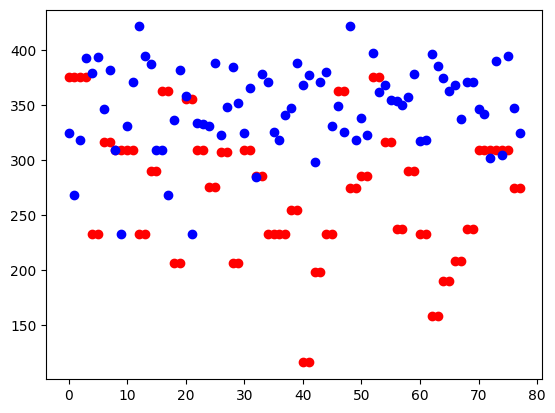

In [291]:
# Visualize eud between some pairs and non-pairs

n = 100

# Pairs
plotX = train_X[train_y == 1][:n]

plotVal = []
for i in range(plotX.shape[0]):
  plotVal.append(eud(plotX[i][0], plotX[i][1]))
print(plotVal)

plt.scatter(range(len(plotVal)), plotVal, c="r")

# Non-Pairs
plotX = train_X[train_y == 0][:n]

plotVal = []
for i in range(plotX.shape[0]):
  plotVal.append(eud(plotX[i][0], plotX[i][1]))
print(plotVal)

plt.scatter(range(len(plotVal)), plotVal, c="b")

plt.show()




### 4. Build the model

In [ ]:
model = Sequential()

